# Testing of 2 UNet Pipeline

Main script for running inference and testing of our two UNet pipeline

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference
from monai.data import Dataset, CacheDataset, DataLoader
from monai.transforms import Activations

from grp_transforms import *
from grp_models import *

In [14]:
in_dir = 'data/nifti_files'
model_dir = 'data/task_results'

device = torch.device("cuda:0")
model = base_unet_w_sigmoid(device) # select model
transforms = unet2_baseline_transforms() # select transforms

In [15]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))

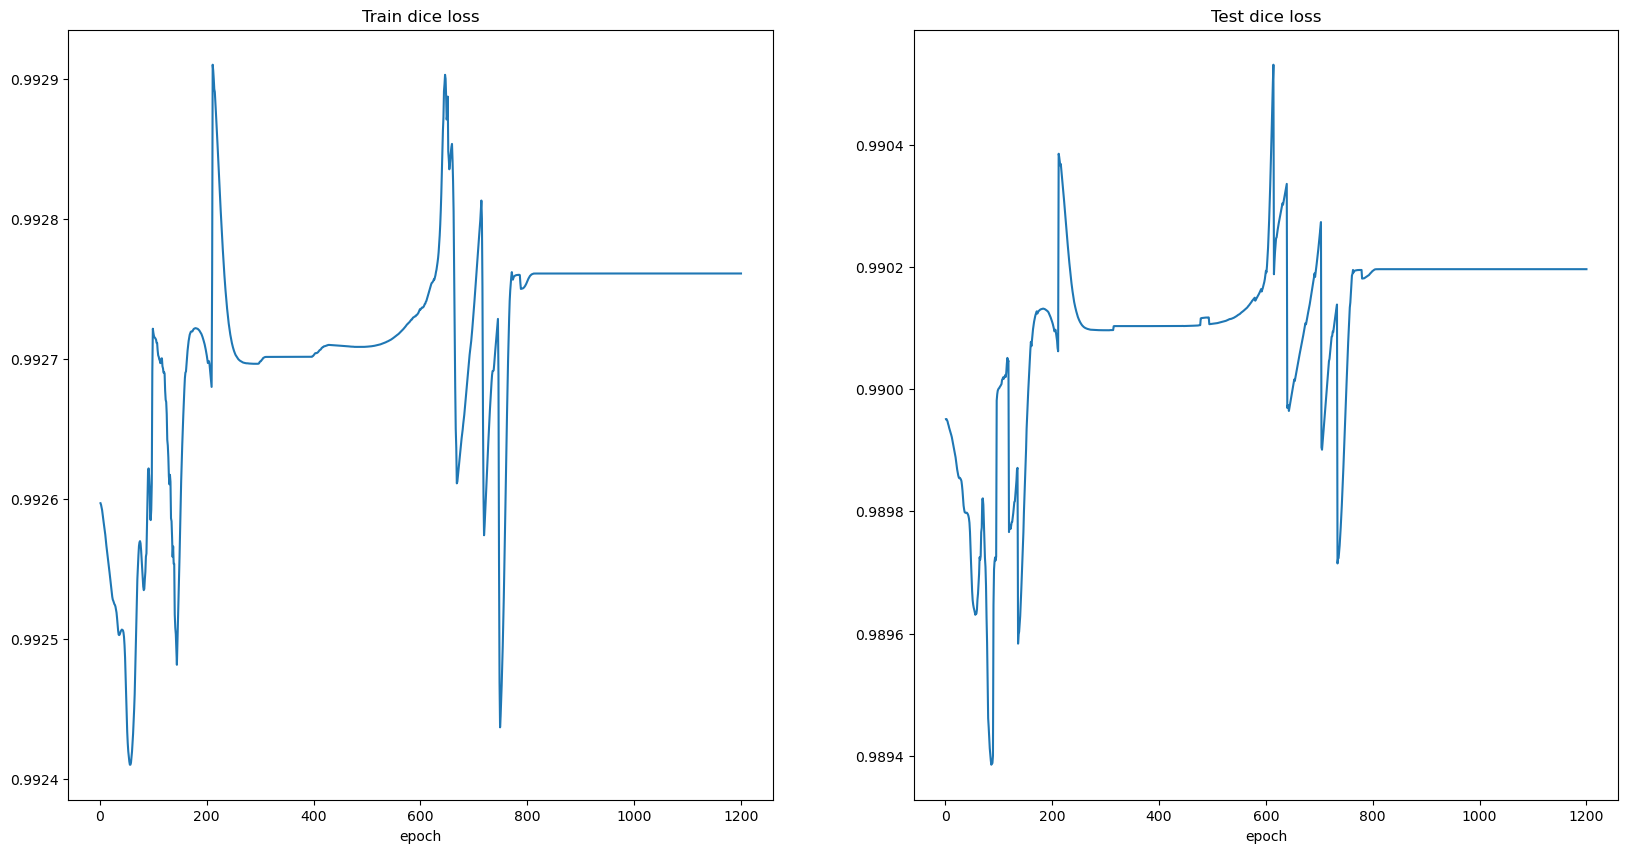

In [16]:
# display params
disp_size = 10
# plots
plt.figure("Training and Eval Losses", (disp_size * 2, disp_size))
# training DICE loss
plt.subplot(1, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)
# testing DICE loss
plt.subplot(1, 2, 2)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [17]:
def load_data(data_dir, transforms, sub_folder_images="images", sub_folder_labels="labels", cache=False):
    image_files = sorted(glob(data_dir + "/" + sub_folder_images + "/*.nii.gz")) # sorted by name to ensure match
    label_files = sorted(glob(data_dir + "/" + sub_folder_labels + "/*.nii.gz"))
    # sanity check: ensure names for both files matches
    for file_pair in zip(image_files, label_files):
        image_name, label_name = file_pair
        assert(os.path.basename(image_name) == os.path.basename(label_name))
    # create dict for volume and segmentation
    files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(image_files, label_files)]
    
    if cache:
        return CacheDataset(data=files, transform=transforms)
    return Dataset(data=files, transform=transforms)

dataset = load_data(in_dir, transforms=transforms)

In [18]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UnetWSMax(
  (model): Sequential(
    (0): UNet(
      (model): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (D): Dropout(p=0.0, inplace=False)
                (A): PReLU(num_parameters=1)
              )
            )
            (unit1): Convolution(
              (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (D): Dropout(p=0.0, inplace=False)
                (A): PReLU(num_parameters=1)
              )
            )
          )
          (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1,

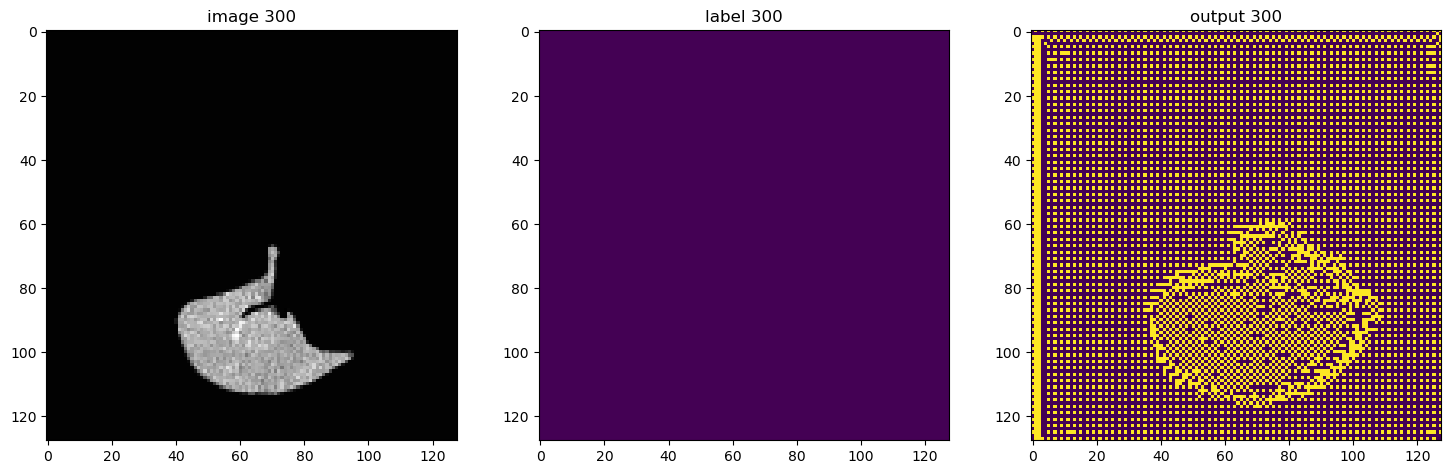

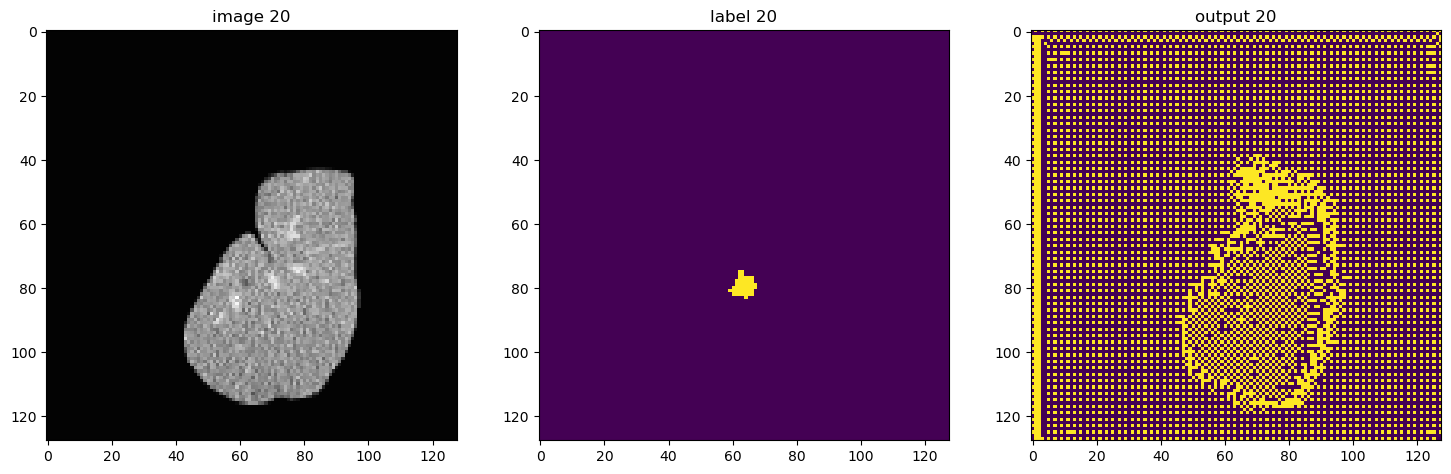

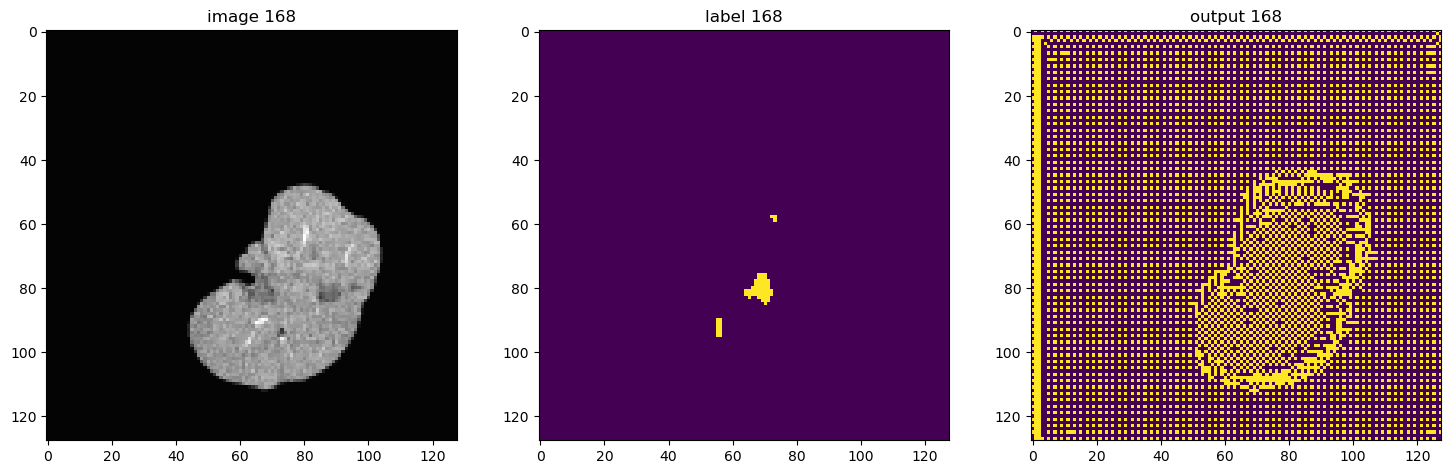

In [19]:
max_sw_batch_size = 4
roi_size = (128, 128, 64)
ind_to_test = [300, 20, 168]
sw_batch_size = min(max_sw_batch_size, len(ind_to_test))

testing_data = dataset[ind_to_test]

with torch.no_grad():
    loader = DataLoader(testing_data, batch_size=len(ind_to_test))

    for test_patient in loader:
        t_volume = test_patient['vol']
        #t_segmentation = test_patient['seg']
        
        test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
        # sigmoid_activation = Activations(sigmoid=True)
        # test_outputs = sigmoid_activation(test_outputs)
        test_outputs = test_outputs > 0.53
            
        for i in range(len(ind_to_test)):
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {ind_to_test[i]}")
            plt.imshow(test_patient["vol"][i, 0, :, :, 0], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {ind_to_test[i]}")
            plt.imshow(test_patient["seg"][i, 0, :, :, 30] != 0)
            plt.subplot(1, 3, 3)
            plt.title(f"output {ind_to_test[i]}")
            plt.imshow(test_outputs.detach().cpu()[i, 0, :, :, 30] == 1)
            plt.show()

In [20]:
# # NOTE: DOES NOT WORK
# # To check why the forward model call is not implemented
# for ind in ind_to_test:
#         raw_outputs = model.forward(dataset[ind]["vol"])
#         print(raw_outputs)